In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt
%matplotlib inline
from sklearn.model_selection import train_test_split
from sklearn.metrics import mutual_info_score
from sklearn.feature_extraction import DictVectorizer
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import roc_auc_score
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb

In [2]:
df = pd.read_csv('https://github.com/gastonstat/CreditScoring/raw/master/CreditScoring.csv')

In [3]:
df.head()

,Status,Seniority,Home,Time,Age,Marital,Records,Job,Expenses,Income,Assets,Debt,Amount,Price
0,1,9,1,60,30,2,1,3,73,129,0,0,800,846
1,1,17,1,60,58,3,1,1,48,131,0,0,1000,1658
2,2,10,2,36,46,2,2,3,90,200,3000,0,2000,2985
3,1,0,1,60,24,1,1,1,63,182,2500,0,900,1325
4,1,0,1,36,26,1,1,1,46,107,0,0,310,910


In [4]:
# Make columns lowercase
new_cols = [col.lower() for col in df.columns]
df.columns = new_cols
df.head()

,status,seniority,home,time,age,marital,records,job,expenses,income,assets,debt,amount,price
0,1,9,1,60,30,2,1,3,73,129,0,0,800,846
1,1,17,1,60,58,3,1,1,48,131,0,0,1000,1658
2,2,10,2,36,46,2,2,3,90,200,3000,0,2000,2985
3,1,0,1,60,24,1,1,1,63,182,2500,0,900,1325
4,1,0,1,36,26,1,1,1,46,107,0,0,310,910


## Data Cleaning

In [5]:
# Creating dictionaries to map R values to categorical
status_values = {
    1: 'ok',
    2: 'default',
    0: 'unk'
}
home_values = {
    1: 'rent',
    2: 'owner',
    3: 'private',
    4: 'ignore',
    5: 'parents',
    6: 'other',
    0: 'unk'
}
marital_values = {
    1: 'single',
    2: 'married',
    3: 'widow',
    4: 'separated',
    5: 'divorced',
    0: 'unk'
}
records_values = {
    1: 'no',
    2: 'yes',
    0: 'unk'
}
job_values = {
    1: 'fixed',
    2: 'parttime',
    3: 'freelance',
    4: 'others',
    0: 'unk'
}

In [6]:
categorical = ['status','home','marital','records','job']
transformed = [status_values, home_values, marital_values, records_values, job_values] 

for col, transformation in zip(categorical, transformed):
    df[col] = df[col].map(transformation)

In [7]:
df.head()

,status,seniority,home,time,age,marital,records,job,expenses,income,assets,debt,amount,price
0,ok,9,rent,60,30,married,no,freelance,73,129,0,0,800,846
1,ok,17,rent,60,58,widow,no,fixed,48,131,0,0,1000,1658
2,default,10,owner,36,46,married,yes,freelance,90,200,3000,0,2000,2985
3,ok,0,rent,60,24,single,no,fixed,63,182,2500,0,900,1325
4,ok,0,rent,36,26,single,no,fixed,46,107,0,0,310,910


In [8]:
df.describe().round()

,seniority,time,age,expenses,income,assets,debt,amount,price
count,4455.0,4455.0,4455.0,4455.0,4455.0,4455.0,4455.0,4455.0,4455.0
mean,8.0,46.0,37.0,56.0,763317.0,1060341.0,404382.0,1039.0,1463.0
std,8.0,15.0,11.0,20.0,8703625.0,10217569.0,6344253.0,475.0,628.0
min,0.0,6.0,18.0,35.0,0.0,0.0,0.0,100.0,105.0
25%,2.0,36.0,28.0,35.0,80.0,0.0,0.0,700.0,1118.0
50%,5.0,48.0,36.0,51.0,120.0,3500.0,0.0,1000.0,1400.0
75%,12.0,60.0,45.0,72.0,166.0,6000.0,0.0,1300.0,1692.0
max,48.0,72.0,68.0,180.0,99999999.0,99999999.0,99999999.0,5000.0,11140.0


In [9]:
# Fixing the '99999999.0' values in income, assets and debt
for col in ['income', 'assets', 'debt']:
    df[col].replace(to_replace=99999999, value=np.nan, inplace=True)

In [10]:
df.describe().round()

,seniority,time,age,expenses,income,assets,debt,amount,price
count,4455.0,4455.0,4455.0,4455.0,4421.0,4408.0,4437.0,4455.0,4455.0
mean,8.0,46.0,37.0,56.0,131.0,5403.0,343.0,1039.0,1463.0
std,8.0,15.0,11.0,20.0,86.0,11573.0,1246.0,475.0,628.0
min,0.0,6.0,18.0,35.0,0.0,0.0,0.0,100.0,105.0
25%,2.0,36.0,28.0,35.0,80.0,0.0,0.0,700.0,1118.0
50%,5.0,48.0,36.0,51.0,120.0,3000.0,0.0,1000.0,1400.0
75%,12.0,60.0,45.0,72.0,165.0,6000.0,0.0,1300.0,1692.0
max,48.0,72.0,68.0,180.0,959.0,300000.0,30000.0,5000.0,11140.0


In [11]:
df.status.value_counts()

status
ok         3200
default    1254
unk           1
Name: count, dtype: int64

In [12]:
# Exclude the 'unk' value in the df
df = df[df['status'] != 'unk']

In [13]:
df_train_full, df_test = train_test_split(df, test_size=0.2, random_state=11)
df_train, df_val = train_test_split(df_train_full, test_size=0.25, random_state=11)

## EDA

In [14]:
df_train_full.isnull().sum()

status        0
seniority     0
home          0
time          0
age           0
marital       0
records       0
job           0
expenses      0
income       30
assets       38
debt         14
amount        0
price         0
dtype: int64

In [15]:
# Fill NAs with zero
df_train_full = df_train_full.fillna(0)

for col, val in dict(df_train_full.isnull().sum()).items():
    assert val == 0, f"error: column {col}"

In [16]:
# Status is the predicted variable
def calculate_mi(series):
    return mutual_info_score(series, df_train_full.status)

df_mi = df_train_full.loc[:, df_train_full.columns != 'status'].apply(calculate_mi)
df_mi = df_mi.sort_values(ascending=False).to_frame(name='MI')
df_mi

,MI
price,0.218639
income,0.093136
amount,0.061396
seniority,0.053949
assets,0.051337
records,0.038154
job,0.036067
expenses,0.029967
debt,0.025425
home,0.024469


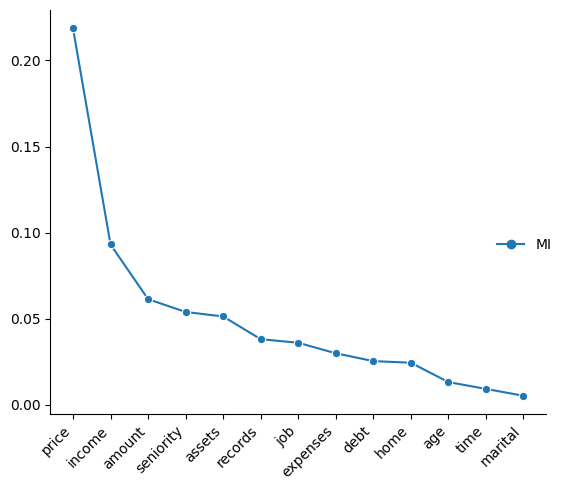

In [17]:
g = sns.relplot(df_mi, kind='line', markers=True)
g.set_xticklabels(rotation=45, ha='right')  # ha = horizontal alignment
plt.tight_layout()  

## Training

In [18]:
# Separate predicted variable
y_train = (df_train.status == 'default').values
y_val = (df_val.status == 'default').values

del df_train['status']
del df_val['status']

In [19]:
# Replace missing values with zero
df_train = df_train.fillna(0)
df_val = df_val.fillna(0)

In [20]:
# DictVectorizer requires a list of dictionaries - convert:
dict_train = df_train.to_dict(orient='records')
dict_val = df_val.to_dict(orient='records')

In [21]:
# Instantiate DictVectorizer and fit to training dataset
dv = DictVectorizer(sparse=False)

X_train = dv.fit_transform(dict_train)
X_val = dv.transform(dict_val)

In [22]:
dv.feature_names_

['age',
 'amount',
 'assets',
 'debt',
 'expenses',
 'home=ignore',
 'home=other',
 'home=owner',
 'home=parents',
 'home=private',
 'home=rent',
 'home=unk',
 'income',
 'job=fixed',
 'job=freelance',
 'job=others',
 'job=parttime',
 'job=unk',
 'marital=divorced',
 'marital=married',
 'marital=separated',
 'marital=single',
 'marital=unk',
 'marital=widow',
 'price',
 'records=no',
 'records=yes',
 'seniority',
 'time']

In [23]:
X_train

array([[3.60e+01, 1.00e+03, 1.00e+04, ..., 0.00e+00, 1.00e+01, 3.60e+01],
       [3.20e+01, 1.10e+03, 0.00e+00, ..., 1.00e+00, 6.00e+00, 4.80e+01],
       [4.00e+01, 1.32e+03, 0.00e+00, ..., 0.00e+00, 1.00e+00, 4.80e+01],
       ...,
       [1.90e+01, 4.00e+02, 0.00e+00, ..., 0.00e+00, 1.00e+00, 2.40e+01],
       [4.30e+01, 2.50e+03, 1.80e+04, ..., 0.00e+00, 1.50e+01, 4.80e+01],
       [2.70e+01, 4.50e+02, 5.00e+03, ..., 1.00e+00, 1.20e+01, 4.80e+01]],
      shape=(2672, 29))

## Decision Tree

In [24]:
# Fit the Decision Tree classifier to the data
dt = DecisionTreeClassifier()
dt.fit(X_train, y_train)

,criterion,'gini'
,splitter,'best'
,max_depth,None
,min_samples_split,2
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_features,None
,random_state,None
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,class_weight,None


In [25]:
# As classification problem, use ROC AUC to check
# Get the y_pred column 1

y_pred = dt.predict_proba(X_train)[:, 1]
roc_auc_score(y_train, y_pred)

1.0

In [26]:
# Test algorithm over different depths
for depth in [1, 2, 3, 4, 5, 6, 10, 15, 20, None]:
    dt = DecisionTreeClassifier(max_depth=depth)
    dt.fit(X_train, y_train)
    y_pred = dt.predict_proba(X_val)[:, 1]
    auc = roc_auc_score(y_val, y_pred)
    print(f"Depth {depth}: {auc:.3f}")

Depth 1: 0.606
Depth 2: 0.669
Depth 3: 0.739
Depth 4: 0.761
Depth 5: 0.767
Depth 6: 0.745
Depth 10: 0.690
Depth 15: 0.663
Depth 20: 0.663
Depth None: 0.649


In [27]:
# max_depth=5 returns best model. Use the 3 highest depth parameters to tune the min_leaf_size.
# Min_leaf_size means that the group needs to be at least a certain size for splitting to occur (prevents overfitting) 

In [28]:
for d in [4, 5, 6]:
    print(f"Depth: {d}")
    for size in [1, 5, 10, 15, 20, 50, 100, 200]:
        dt = DecisionTreeClassifier(max_depth=d, min_samples_leaf=size)
        dt.fit(X_train, y_train)
        y_pred = dt.predict_proba(X_val)[:, 1]
        auc = roc_auc_score(y_val, y_pred)
        print(f"\tMin leaf size {size}: {auc:.3f}")

Depth: 4
	Min leaf size 1: 0.761
	Min leaf size 5: 0.761
	Min leaf size 10: 0.761
	Min leaf size 15: 0.764
	Min leaf size 20: 0.761
	Min leaf size 50: 0.753
	Min leaf size 100: 0.756
	Min leaf size 200: 0.747
Depth: 5
	Min leaf size 1: 0.766
	Min leaf size 5: 0.768
	Min leaf size 10: 0.762
	Min leaf size 15: 0.773
	Min leaf size 20: 0.774
	Min leaf size 50: 0.768
	Min leaf size 100: 0.763
	Min leaf size 200: 0.759
Depth: 6
	Min leaf size 1: 0.754
	Min leaf size 5: 0.762
	Min leaf size 10: 0.778
	Min leaf size 15: 0.785
	Min leaf size 20: 0.774
	Min leaf size 50: 0.772
	Min leaf size 100: 0.776
	Min leaf size 200: 0.768


In [29]:
# Further tuning over smaller range
for d in [4, 5, 6]:
    print(f"Depth: {d}")
    for size in list(range(10, 20)):
        dt = DecisionTreeClassifier(max_depth=d, min_samples_leaf=size)
        dt.fit(X_train, y_train)
        y_pred = dt.predict_proba(X_val)[:, 1]
        auc = roc_auc_score(y_val, y_pred)
        print(f"\tMin leaf size {size}: {auc:.3f}")

Depth: 4
	Min leaf size 10: 0.761
	Min leaf size 11: 0.763
	Min leaf size 12: 0.763
	Min leaf size 13: 0.763
	Min leaf size 14: 0.763
	Min leaf size 15: 0.764
	Min leaf size 16: 0.764
	Min leaf size 17: 0.759
	Min leaf size 18: 0.759
	Min leaf size 19: 0.759
Depth: 5
	Min leaf size 10: 0.762
	Min leaf size 11: 0.763
	Min leaf size 12: 0.763
	Min leaf size 13: 0.769
	Min leaf size 14: 0.770
	Min leaf size 15: 0.772
	Min leaf size 16: 0.775
	Min leaf size 17: 0.769
	Min leaf size 18: 0.772
	Min leaf size 19: 0.772
Depth: 6
	Min leaf size 10: 0.778
	Min leaf size 11: 0.781
	Min leaf size 12: 0.780
	Min leaf size 13: 0.778
	Min leaf size 14: 0.779
	Min leaf size 15: 0.785
	Min leaf size 16: 0.791
	Min leaf size 17: 0.772
	Min leaf size 18: 0.774
	Min leaf size 19: 0.774


## Random Forest

In [30]:
# n_estimators is the number of trees in the ensemble model
rf = RandomForestClassifier(n_estimators=10, random_state=3)
rf.fit(X_train, y_train)
y_pred = rf.predict_proba(X_val)[:, 1]
roc_auc_score(y_val, y_pred)

0.7811145285897654

In [31]:
aucs = dict()
for i in range(10, 201, 10):
    rf = RandomForestClassifier(n_estimators=i, random_state=3)
    rf.fit(X_train, y_train)
    y_pred = rf.predict_proba(X_val)[:, 1]
    auc = roc_auc_score(y_val, y_pred)
    aucs[i] = auc

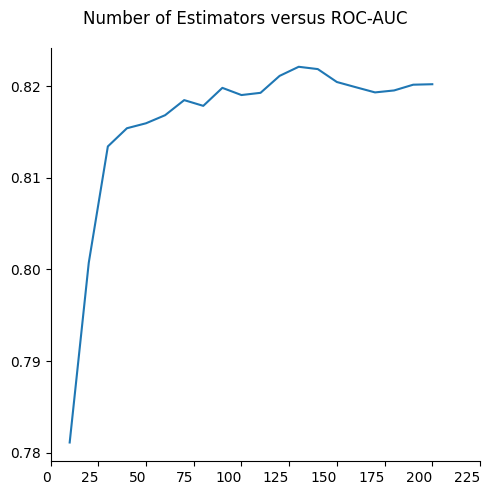

In [32]:
g = sns.relplot(aucs, kind='line', markers=True)
g.set_xticklabels(rotation=0, ha='right')  # ha = horizontal alignment
g.fig.suptitle('Number of Estimators versus ROC-AUC')
plt.tight_layout()

In [33]:
# Tuning other parameters
all_aucs = dict()

for depth in [4, 5, 6, 10, 20]:
    print(f"Depth: {depth}")
    aucs = []

    for i in range(10, 201, 10):
        rf = RandomForestClassifier(n_estimators=i, max_depth=depth, random_state=1)
        rf.fit(X_train, y_train)
        y_pred = rf.predict_proba(X_val)[:, 1]
        auc = roc_auc_score(y_val, y_pred)
        print(f"  Estimators {i}: ROC-AUC {auc:.3f}")
        aucs.append(auc)
    all_aucs[depth] = aucs
    print()

Depth: 4
  Estimators 10: ROC-AUC 0.778
  Estimators 20: ROC-AUC 0.798
  Estimators 30: ROC-AUC 0.796
  Estimators 40: ROC-AUC 0.796
  Estimators 50: ROC-AUC 0.796
  Estimators 60: ROC-AUC 0.798
  Estimators 70: ROC-AUC 0.798
  Estimators 80: ROC-AUC 0.798
  Estimators 90: ROC-AUC 0.799
  Estimators 100: ROC-AUC 0.799
  Estimators 110: ROC-AUC 0.801
  Estimators 120: ROC-AUC 0.802
  Estimators 130: ROC-AUC 0.803
  Estimators 140: ROC-AUC 0.802
  Estimators 150: ROC-AUC 0.802
  Estimators 160: ROC-AUC 0.802
  Estimators 170: ROC-AUC 0.802
  Estimators 180: ROC-AUC 0.802
  Estimators 190: ROC-AUC 0.802
  Estimators 200: ROC-AUC 0.802

Depth: 5
  Estimators 10: ROC-AUC 0.788
  Estimators 20: ROC-AUC 0.798
  Estimators 30: ROC-AUC 0.800
  Estimators 40: ROC-AUC 0.800
  Estimators 50: ROC-AUC 0.800
  Estimators 60: ROC-AUC 0.801
  Estimators 70: ROC-AUC 0.802
  Estimators 80: ROC-AUC 0.803
  Estimators 90: ROC-AUC 0.804
  Estimators 100: ROC-AUC 0.804
  Estimators 110: ROC-AUC 0.807
  Estim

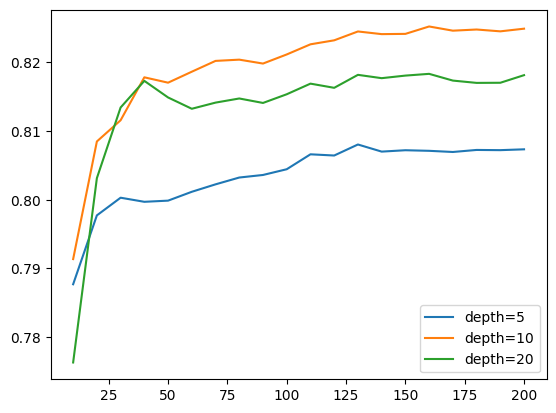

In [34]:
num_trees = list(range(10, 201, 10))
plt.plot(num_trees, all_aucs[5], label='depth=5')
plt.plot(num_trees, all_aucs[10], label='depth=10')
plt.plot(num_trees, all_aucs[20], label='depth=20')
plt.legend()

In [35]:
all_aucs = {}
for m in [3, 5, 10]:
    print('min_samples_leaf: %s' % m)
    aucs = []
    for i in range(10, 201, 20):
        rf = RandomForestClassifier(n_estimators=i, max_depth=10, min_samples_leaf=m, random_state=1)
        rf.fit(X_train, y_train)
        y_pred = rf.predict_proba(X_val)[:, 1]
        auc = roc_auc_score(y_val, y_pred)
        print('%s -> %.3f' % (i, auc))
        aucs.append(auc)
    all_aucs[m] = aucs
    print()

min_samples_leaf: 3
10 -> 0.811
30 -> 0.823
50 -> 0.823
70 -> 0.822
90 -> 0.823
110 -> 0.823
130 -> 0.824
150 -> 0.825
170 -> 0.825
190 -> 0.825

min_samples_leaf: 5
10 -> 0.813
30 -> 0.818
50 -> 0.821
70 -> 0.822
90 -> 0.822
110 -> 0.825
130 -> 0.825
150 -> 0.825
170 -> 0.825
190 -> 0.826

min_samples_leaf: 10
10 -> 0.810
30 -> 0.822
50 -> 0.822
70 -> 0.819
90 -> 0.820
110 -> 0.820
130 -> 0.821
150 -> 0.820
170 -> 0.820
190 -> 0.820



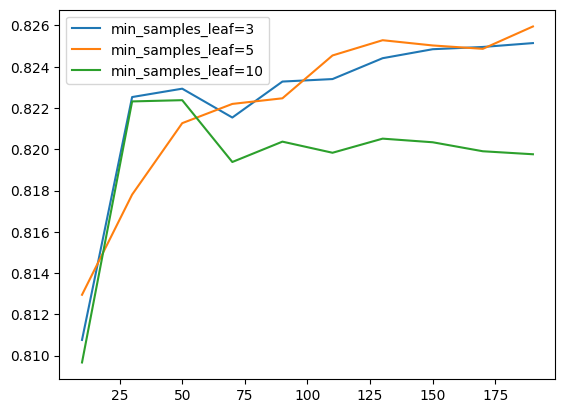

In [36]:
num_trees = list(range(10, 201, 20))
plt.plot(num_trees, all_aucs[3], label='min_samples_leaf=3')
plt.plot(num_trees, all_aucs[5], label='min_samples_leaf=5')
plt.plot(num_trees, all_aucs[10], label='min_samples_leaf=10')
plt.legend()

In [37]:
# Final parameters are n_estimators=200, max_depth=10, min_samples_leaf=5.

## Gradient Boosting

In [38]:
# data needs to be in a DMatrix
dtrain = xgb.DMatrix(X_train, label=y_train, feature_names=dv.feature_names_)
dval = xgb.DMatrix(X_val, label=y_val, feature_names=dv.feature_names_)

In [39]:
xgb_params = {
    'eta': 0.3,
    'max_depth': 6,
    'min_child_weight': 1,
    'objective': 'binary:logistic',
    'nthread': 8,
    'seed': 1,
    'silent': 1
}

In [40]:
# Train with 10 trees as a start
model = xgb.train(xgb_params, dtrain, num_boost_round=10)

C:\Users\heath\miniconda3\envs\ML-Bookcamp\Lib\site-packages\xgboost\training.py:199: UserWarning: [08:56:54] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:790: 
Parameters: { "silent" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


In [41]:
y_pred = model.predict(dval)

In [42]:
roc_auc_score(y_val, y_pred)

0.8118506454190986

In [43]:
# Model performance monitoring

xgb_params = {
    'eta': 0.3,
    'max_depth': 6,
    'min_child_weight': 1,
    'objective': 'binary:logistic',
    'nthread': 8,
    'seed': 1,
    'silent': 1,
    'eval_metric': 'auc'
}

In [44]:
# Watchlist
watchlist = [(dtrain, 'train'), (dval, 'val')]

In [45]:
model = xgb.train(xgb_params, dtrain, num_boost_round=100, evals=watchlist, verbose_eval=10)

[0]	train-auc:0.86653	val-auc:0.77999
[10]	train-auc:0.95512	val-auc:0.81115
[20]	train-auc:0.97648	val-auc:0.81877
[30]	train-auc:0.98844	val-auc:0.81613
[40]	train-auc:0.99393	val-auc:0.81407


C:\Users\heath\miniconda3\envs\ML-Bookcamp\Lib\site-packages\xgboost\training.py:199: UserWarning: [08:56:54] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:790: 
Parameters: { "silent" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[50]	train-auc:0.99723	val-auc:0.81276
[60]	train-auc:0.99861	val-auc:0.81244
[70]	train-auc:0.99962	val-auc:0.81243
[80]	train-auc:0.99989	val-auc:0.81359
[90]	train-auc:0.99998	val-auc:0.81038
[99]	train-auc:0.99999	val-auc:0.80838


In [46]:
# Changing eta - controls the learning rate 0.3 to 0.1
xgb_params = {
    'eta': 0.1,
    'max_depth': 6,
    'min_child_weight': 1,
    'objective': 'binary:logistic',
    'nthread': 8,
    'seed': 1,
    'silent': 1,
    'eval_metric': 'auc'
}

# Train for more iterations 
model = xgb.train(xgb_params, dtrain, num_boost_round=500, verbose_eval=10, evals=watchlist)

[0]	train-auc:0.86653	val-auc:0.77999
[10]	train-auc:0.91936	val-auc:0.80573
[20]	train-auc:0.94007	val-auc:0.81551
[30]	train-auc:0.95175	val-auc:0.81942
[40]	train-auc:0.96125	val-auc:0.82243
[50]	train-auc:0.96869	val-auc:0.82559
[60]	train-auc:0.97493	val-auc:0.82736
[70]	train-auc:0.97937	val-auc:0.82631
[80]	train-auc:0.98397	val-auc:0.82811
[90]	train-auc:0.98770	val-auc:0.82851
[100]	train-auc:0.99024	val-auc:0.82711
[110]	train-auc:0.99222	val-auc:0.82692
[120]	train-auc:0.99392	val-auc:0.82615
[130]	train-auc:0.99532	val-auc:0.82555
[140]	train-auc:0.99615	val-auc:0.82531
[150]	train-auc:0.99679	val-auc:0.82529
[160]	train-auc:0.99792	val-auc:0.82328
[170]	train-auc:0.99854	val-auc:0.82380
[180]	train-auc:0.99887	val-auc:0.82378
[190]	train-auc:0.99916	val-auc:0.82288
[200]	train-auc:0.99938	val-auc:0.82214
[210]	train-auc:0.99953	val-auc:0.82089
[220]	train-auc:0.99962	val-auc:0.81993
[230]	train-auc:0.99971	val-auc:0.81925
[240]	train-auc:0.99982	val-auc:0.81907
[250]	train

In [47]:
# Max depth
xgb_params = {
    'eta': 0.1,
    'max_depth': 3,
    'min_child_weight': 1,
    'objective': 'binary:logistic',
    'nthread': 8,
    'seed': 1,
    'silent': 1,
    'eval_metric': 'auc'
}
# Train for more iterations due to smaller learning rate
model = xgb.train(xgb_params, dtrain, num_boost_round=500, verbose_eval=10, evals=watchlist)

[0]	train-auc:0.77610	val-auc:0.73891
[10]	train-auc:0.85036	val-auc:0.79448
[20]	train-auc:0.86898	val-auc:0.80852
[30]	train-auc:0.88186	val-auc:0.81747
[40]	train-auc:0.88961	val-auc:0.82042
[50]	train-auc:0.89673	val-auc:0.82755
[60]	train-auc:0.90252	val-auc:0.82725
[70]	train-auc:0.90859	val-auc:0.82809
[80]	train-auc:0.91216	val-auc:0.82920
[90]	train-auc:0.91623	val-auc:0.83121
[100]	train-auc:0.91922	val-auc:0.83093


C:\Users\heath\miniconda3\envs\ML-Bookcamp\Lib\site-packages\xgboost\training.py:199: UserWarning: [08:56:56] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:790: 
Parameters: { "silent" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[110]	train-auc:0.92290	val-auc:0.83152
[120]	train-auc:0.92517	val-auc:0.83134
[130]	train-auc:0.92785	val-auc:0.83193
[140]	train-auc:0.92981	val-auc:0.83304
[150]	train-auc:0.93222	val-auc:0.83358
[160]	train-auc:0.93392	val-auc:0.83406
[170]	train-auc:0.93624	val-auc:0.83350
[180]	train-auc:0.93804	val-auc:0.83380
[190]	train-auc:0.94029	val-auc:0.83338
[200]	train-auc:0.94222	val-auc:0.83221
[210]	train-auc:0.94401	val-auc:0.83227
[220]	train-auc:0.94496	val-auc:0.83251
[230]	train-auc:0.94650	val-auc:0.83195
[240]	train-auc:0.94824	val-auc:0.83185
[250]	train-auc:0.94963	val-auc:0.83092
[260]	train-auc:0.95115	val-auc:0.83045
[270]	train-auc:0.95261	val-auc:0.83084
[280]	train-auc:0.95416	val-auc:0.83062
[290]	train-auc:0.95495	val-auc:0.83000
[300]	train-auc:0.95625	val-auc:0.82998
[310]	train-auc:0.95723	val-auc:0.82877
[320]	train-auc:0.95884	val-auc:0.82817
[330]	train-auc:0.95993	val-auc:0.82768
[340]	train-auc:0.96127	val-auc:0.82810
[350]	train-auc:0.96228	val-auc:0.82761
